### Build and Plot a Classification Tree (from Scratch)
In this implementation, I've created a classification tree from scratch using the logic we covered in the course: 
The tree splits the dataset recursively by selecting the feature with the **highest Information Gain (IG)** until we reach **pure leaves** or run out of features (in this last case the majority class is chosen). Note that I haven't incorporated additional stopping criteria such as a minimum number of observations per leaf or a maximum tree depth.

In the first part of the code, I defined the logic for calculating Entropy and Information Gain, as well as for building the tree recursively. Then, I included the code to visualize (plot) the resulting tree.

With this setup, you can easily build and visualize a classification tree for any dataset. To use it, simply provide your dataset in a Pandas DataFrame, specify the target variable (i.e., the class label to predict), and define the positive class (such as "Yes", "True", or "T"). After that, you can run the two methods to build and plot the tree.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# Entropy calculation
def entropy(variable):
    _, counts = np.unique(variable, return_counts=True)
    probabilities = counts / counts.sum()
    return -sum(probabilities * np.log2(probabilities))

# Information Gain (IG) calculation
def information_gain(data, feature, target):
    total_entropy = entropy(data[target])
    values, counts = np.unique(data[feature], return_counts=True)
    weighted_entropy = sum(
        # For each unique value of the feature, we compute the entropy of the subset where the feature equals that value, weighted by the 
        # proportion of samples that have that value
        (counts[i] / sum(counts)) * entropy(data[data[feature] == values[i]][target]) for i in range(len(values))
    )
    return total_entropy - weighted_entropy

# Recursive tree-building function
def build_tree(data, features, target):
    # This function builds the decision tree recursively. It splits the data based on the best feature (the one with the highest IG), and
    # it continues splitting until the base cases are met.
    
    # Base case: If all target values are the same (i.e., the dataset is pure), return that value. This means that the current node is a leaf node.
    if len(np.unique(data[target])) == 1:
        return np.unique(data[target])[0]
    # Base case: if no features left, return the majority class
    if len(features) == 0:
        return data[target].mode()[0]
    

    # Calculate the IG for all features and selects the feature with the highest gain (it will be used as the best feature to split the data)
    gains = {feature: information_gain(data, feature, target) for feature in features}
    best_feature = max(gains, key=gains.get)
    
    # Initialize the tree as a dictionary
    tree = {best_feature: {}}
    
    # Split the dataset on the best feature
    feature_values = np.unique(data[best_feature])
    for value in feature_values:
        subset = data[data[best_feature] == value]
        
        # If the subset is pure, add it as a leaf node
        if len(np.unique(subset[target])) == 1:
            tree[best_feature][value] = np.unique(subset[target])[0]
        else:
            # Otherwise, build a subtree
            remaining_features = [f for f in features if f != best_feature]
            # Note: In building the new subtree consider just the subset of data of that feature value and the remaining features 
            tree[best_feature][value] = build_tree(subset, remaining_features, target)
    
    return tree

In [10]:
# Recursive tree-plotting function
def plot_tree(tree, pos=(0.5, 1), depth=0, offset=0.2, positive_class='T'): 
    _, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    plot_subtree(tree, ax, pos, depth, offset, positive_class)
    plt.show()

def plot_subtree(tree, ax, pos, depth, offset, positive_class):
    if isinstance(tree, dict):
        # Get the current node (feature) and its children
        feature = list(tree.keys())[0]
        children = tree[feature]
        
        # Draw the current node (feature)
        ax.text(*pos, feature, bbox=dict(boxstyle='round', facecolor='lightblue'), ha='center')
        
        # This is used just to adjust the offset for better spacing, based on the number of children
        num_children = len(children)
        child_offset = offset * 2.5 / num_children
        
        # Plot each child node recursively
        for i, (value, subtree) in enumerate(children.items()):
            # Calculate the child's position
            child_pos = (pos[0] - child_offset * (num_children - 1) / 2 + i * child_offset, pos[1] - 0.1)
            # Draw connecting line
            ax.plot([pos[0], child_pos[0]], [pos[1], child_pos[1]], color='gray')
            # Draw the value label on the line
            ax.text((pos[0] + child_pos[0]) / 2, (pos[1] + child_pos[1]) / 2, value,
                    ha='center', va='center', color='darkblue')
            
            # Recursively plot the subtree
            plot_subtree(subtree, ax, child_pos, depth + 1, child_offset / 1.5, positive_class)
    else:
        # Determine color based on whether the leaf matches the positive class
        color = 'lightgreen' if tree == positive_class else 'lightcoral'
        # Draw a leaf node (prediction value)
        ax.text(*pos, f'{tree}', bbox=dict(boxstyle='round', facecolor=color), ha='center')


Below are shown some examples of its usage ...

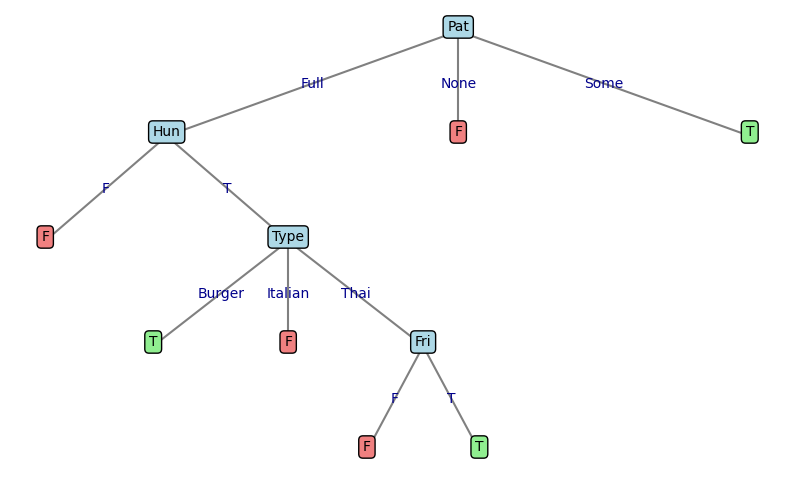

In [11]:
# Dataset
data = pd.DataFrame({
    'Alt': ['T', 'T', 'F', 'T', 'T', 'F', 'F', 'F', 'F', 'T', 'F', 'T'],
    'Bar': ['F', 'F', 'T', 'F', 'F', 'T', 'T', 'F', 'T', 'T', 'F', 'T'],
    'Fri': ['F', 'F', 'F', 'T', 'T', 'F', 'F', 'F', 'T', 'T', 'F', 'T'],
    'Hun': ['T', 'T', 'F', 'T', 'F', 'T', 'F', 'T', 'F', 'T', 'F', 'T'],
    'Pat': ['Some', 'Full', 'Some', 'Full', 'Full', 'Some', 'None', 'Some', 'Full', 'Full', 'None', 'Full'],
    'Price': ['$$$', '$', '$', '$', '$$$', '$$', '$', '$$', '$', '$$$', '$', '$'],
    'Rain': ['F', 'F', 'F', 'F', 'F', 'T', 'T', 'T', 'T', 'F', 'F', 'F'],
    'Res': ['T', 'F', 'F', 'F', 'T', 'T', 'F', 'T', 'F', 'T', 'F', 'F'],
    'Type': ['French', 'Thai', 'Burger', 'Thai', 'French', 'Italian', 'Burger', 'Thai', 'Burger', 'Italian', 'Thai', 'Burger'],
    'Est': ['0-10', '30-60', '0-10', '10-30', '>60', '0-10', '0-10', '0-10', '>60', '10-30', '0-10', '30-60'],
    'WillWait': ['T', 'F', 'T', 'T', 'F', 'T', 'F', 'T', 'F', 'F', 'F', 'T']
})

# Specify target variable and the value of the target positive class
target = 'WillWait'
positive_class='T'

features = [col for col in data.columns if col != target]

# Build the tree and plot it
decision_tree = build_tree(data, features, target)
plot_tree(decision_tree, positive_class=positive_class)

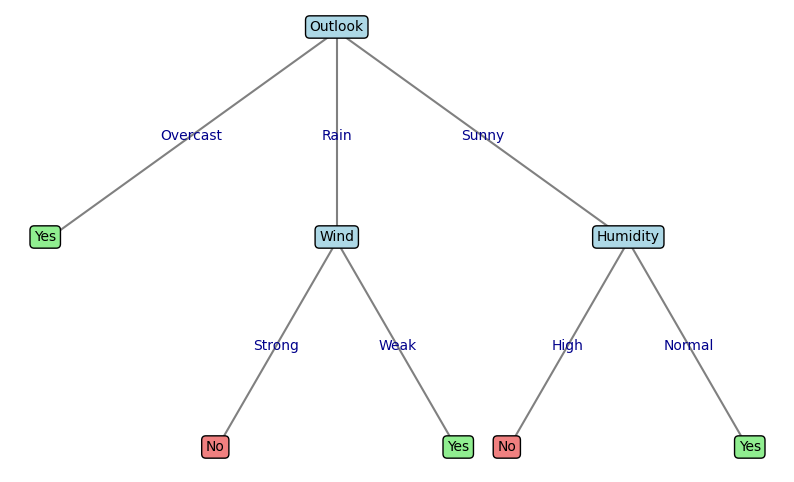

In [12]:
data = pd.DataFrame({
    #'Day': ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14'],
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
    'PlayTennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
})

target = 'PlayTennis'
positive_class='Yes'

features = [col for col in data.columns if col != target]

# Build the tree and plot it
decision_tree = build_tree(data, features, target)
plot_tree(decision_tree, positive_class=positive_class)

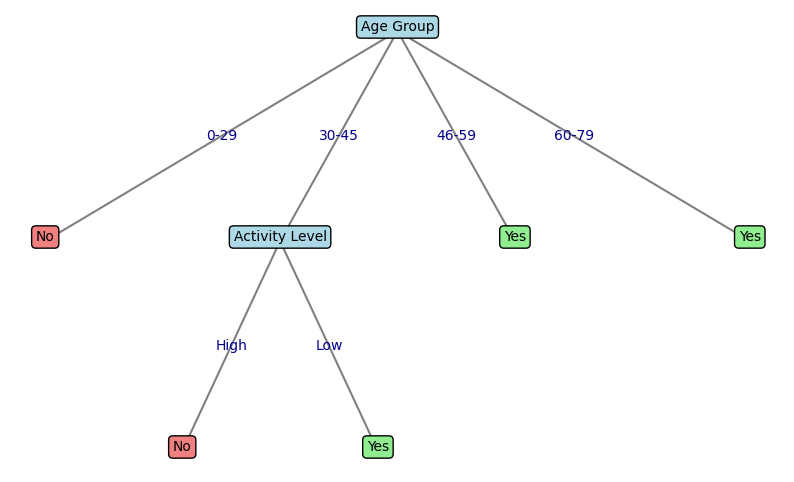

In [13]:
data = pd.DataFrame({
    'Age Group': ['0-29', '30-45', '46-59', '0-29', '60-79', '30-45', '0-29', '46-59', '60-79', '30-45'],
    'BMI Category': ['Normal', 'Overweight', 'Obese', 'Normal', 'Obese', 'Overweight', 'Normal', 'Overweight', 'Obese', 'Normal'],
    'Family History of Diabetes': ['Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes'],
    'Activity Level': ['High', 'Low', 'Medium', 'Medium', 'Low', 'High', 'Low', 'Medium', 'Low', 'Low'],
    'Diabetes Risk': ['No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes']
})

target = 'Diabetes Risk'
positive_class='Yes'

features = [col for col in data.columns if col != target]

# Build the tree and plot it
decision_tree = build_tree(data, features, target)
plot_tree(decision_tree, positive_class=positive_class)